# DEEPMIND ALPHAZERO CHESS

## TODO
- Fix MCTS UCB Calculation... Pseudocode different from paper
- Seperate training and actors.. IMPORTANT! Handle this 
- Learning rate schedule. 0.2, 0.02, 0.002, 0.0002 after 100k, 300k, 500k games
- Have training on GPU and inference CPU
- Implement https://www.youtube.com/watch?v=a4VvcmqnkhY
- print(f"INVALID ACTION {action}.\nSELECTING A RANDOM ACTION FROM LEGAL ACTIONS\n{self.legal_actions()}") #### DISABLED FOR VIEWING PRINTS PROPERLY!


## TODO LATER
#### - Get backward possibly loss to train the controller. Might need to save the tensor output like states, values, etc in MCTS
- Create Self play class
- Create Arena class

DEEP MIND OPEN ACCESS PAPER 

https://kstatic.googleusercontent.com/files/2f51b2a749a284c2e2dfa13911da965f4855092a179469aedd15fbe4efe8f8cbf9c515ef83ac03a6515fa990e6f85fd827dcd477845e806f23a17845072dc7bd

DEEP MIND OPEN ACCESS PAPER SUPPLEMENTARY MATERIALS

https://science.sciencemag.org/content/sci/suppl/2018/12/05/362.6419.1140.DC1/aar6404-Silver-SM.pdf

RAY ALPHA ZERO IMPLEMENTATION 

https://github.com/ray-project/ray/tree/master/rllib/contrib/alpha_zero

DUPLICATED MCTS IMPLEMENTATION

https://github.com/suragnair/alpha-zero-general/blob/master/MCTS.py

DISTRIBUTED IMPLEMENTATION

https://github.com/mokemokechicken/reversi-alpha-zero/blob/master/src/reversi_zero/lib/ggf.py

CHESS MOVES

https://www.ichess.net/blog/chess-pieces-moves/

BOARD REPRESENTATIONS

https://medium.com/datadriveninvestor/reconstructing-chess-positions-f195fd5944e

ALPHA ZERO EXPLANATION

https://nikcheerla.github.io/deeplearningschool/2018/01/01/AlphaZero-Explained/

TRANSFORMER NETWORK IMPLEMENTATION

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [1]:
PARALLEL = False

if PARALLEL:
    !pip install --user python-chess gym colorama tqdm PyQt5 ray tensorboard

In [2]:
if PARALLEL:
    import ray
    ray.init()

import chess, gym, pickle, random, torch, math
import chess.svg as svg
import numpy as np
import pandas as pd
from copy import copy, deepcopy
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.optim import Adam
import torch.nn as nn
from torch.nn import functional as F
from torch.distributions import Categorical

from scipy.ndimage.interpolation import shift
from copy import deepcopy
from colorama import init, Fore, Back, Style
from collections import Counter, deque
from tqdm import tqdm, tnrange, notebook
from random import shuffle
import tkinter as tk
from tkinter import simpledialog
from PyQt5.QtSvg import QSvgWidget
from PyQt5.QtWidgets import QApplication, QWidget

from utilities import *
from constants import *
from models.vae import CNN_AE, CNN_VAE, train_ae, train_vae, Conv
from models.mdn import MDN_RNN, loss_function, clip_grad_norm_
from models.controller import Policy_Controller, Value_Controller
plt.style.use('ggplot')
# init(convert = True)

# MONTE CARLO TREE SEARCH

In [3]:
class MCTS():
    """Monte Carlo Tree Search Algorithm geared for Neural Networks"""

    def __init__(self, env, agent, mcts_simulations = 100):
        self.env = env
        self.agent = agent
        
        # Exploration bonus
        self.cpuct_init = 1.25                       
        self.cpuct_base = 19652
        self.mcts_simulations = mcts_simulations
        
        self.Qsa = {}                               # stores Q values for s, a (as defined in the paper)
        self.Wsa = {}                               # stores the total action value
        self.Nsa = {}                               # stores # times edge s, a was visited
        self.Ns = {}                                # stores # times board s was visited
        self.Ps = {}                                # stores prior probability of selecting a in s

        self.Es = {}                                # stores victory result (1, 0, -1) ended for board s
        self.z = {}                                 # stores the features of the state
        self.hidden = {}                            # stores the hidden states
        
        # Exploration noise parameters, used in action probabiltiies 
        self.dirichlet_alpha = 0.3  
        self.exploration_fraction = 0.25


    def action_probabilities(self, encoded_state, evaluate = False):
        """
        Runs n number of monte carlo simulation, updates the tree and provides
        an action selection probability distribution with as well an encoded representation
        of the state with historical information zh
        """
        for runs in range(self.mcts_simulations):
            self.search(encoded_state, 0)
        
        s = encoded_state
        self.env.decode(encoded_state)
        legal_actions = self.env.legal_actions()
        
        # counts array represent the number of time each action edge from your current state was traversed
        counts = [self.Nsa[(s,a)] if (s,a) in self.Nsa else 0 for a in legal_actions]
        
        zh = torch.cat((self.z[s].to('cpu'), self.hidden[s][0].squeeze(0).to('cpu')), dim = 1)
        # temprature is 0 representing taking the best action possible (greedy)
        if evaluate: 
            # bestA: best action number : argmax Returns the indices of the maximum values
            bestA = np.argmax(counts) 
            probs = [0] * len(counts)
            probs[bestA] = 1
            action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}
            # returns the definite move(s) with same greedy reward, out of which one move HAS to be played
            return action_probs, zh
        
#         print(f"{Fore.BLUE}COUNTS {sum(counts)} {counts}{Style.RESET_ALL}")
        
        # Handles frequent draw situation when MCTS fails to explore when the game is over resulting 0 counts causing div 0 error
        # Dirichlet noise handles this
        #         if sum(counts) == 0:
#             counts = [1 for _ in counts]
        
        # Add the dirichlet noise to encourage exploration 
        noise = np.random.gamma(self.dirichlet_alpha, 1, len(legal_actions))
        
        frac = self.exploration_fraction
        for idx, (a, noise_) in enumerate(zip(legal_actions, noise)):
            counts[idx] = counts[idx] * (1 - frac) + noise_ * frac
        
        probs = [x / float(sum(counts)) for x in counts]
        action_probs = {legal_actions[idx] : probs[idx] for idx in range(len(legal_actions))}

        return action_probs, zh
        #returns the probablity of different moves that CAN be played resulting in uniform distribution


    def search(self, encoded_state, depth):
        """
        This function performs one iteration of MCTS. It is recursively called
        till a leaf node is found. The action chosen at each node is one that
        has the maximum upper confidence bound as in the paper.
        Once a leaf node is found, the neural network is called to return an
        initial policy P and a value v for the state. This value is propogated
        up the search path. In case the leaf node is a terminal state, the
        outcome is propogated up the search path. The values of Ns, Nsa, Qsa, Wsa are
        updated.
        
        NOTE: the return values are the negative of the value of the current
        state. This is done since v is in [-1,1] and if v is the value of a
        state for the current player, then its value is -v for the other player.
        """

        s = deepcopy(encoded_state)
        self.env.decode(encoded_state)
#         print(f"{Fore.GREEN}SEARCH DEPTH {depth}{Style.RESET_ALL}")
        
        # Handles the maintaining of the MDNs hidden states
        if s not in self.hidden:
            self.hidden[s] = self.agent.get_hidden()
        else:
            self.agent.load_hidden(self.hidden[s])
        
        state, legal_actions = self.env.observe()
            
        # Check if its an terminal state, -1 Opponent Won, 0 Draw or Game not over, 1 Player Won
        if self.env.terminal_test():
            state, _ = self.env.observe()
            
            # Stores the AE encoded representation of current state
            self.z[s] = self.agent.encode_z(state)
            
            # Intialize the edges of the state
            for a in legal_actions:
                self.Wsa[(s,a)] = 0
                self.Qsa[(s,a)] = 0
                self.Nsa[(s,a)] = 0
#             print("SIMULATION OVER!", self.env.terminal_test(), -self.Es[s], self.env.board.result())
            return -self.env.result()        

        # Intialize the new node at state s with agents policy and value estimate
        if s not in self.Ps: 
            self.Ps[s], v, self.z[s] = self.agent.act(state, legal_actions)
#             print("self.Ps[s] at Depth", depth, "\n", self.Ps[s])
            self.Ns[s] = 0
    
            # Intialize the edges of the state
            for a in legal_actions:
                self.Wsa[(s,a)] = 0
                self.Qsa[(s,a)] = 0
                self.Nsa[(s,a)] = 0
            return -v

        self.env.decode(encoded_state)
        
        # Compare agents action estimates with actual legal actions
        legal_actions = self.env.legal_actions()
        agent_actions = list(self.Ps[s].keys())
        
        # Handles the occasional legal action that isn't an actual legal action
        # Pawn side cut even though there is no enemy piece in respective position
        if not set(agent_actions) == set(legal_actions):
            legal_actions = agent_actions

        # Update exploration rate as the search gets deeper to explore more
        cpuct = math.log((1 + self.Ns[s] + self.cpuct_base) / self.cpuct_base) + self.cpuct_init
        cpuct *= math.sqrt(self.Ns[s] / (self.Ns[s] + 1))

        # Calculate UCB Upper Confidence Bound based on the 
        # Value estimate, exploration rate, agents policy and frequency of edge visits
        ucb = {}
        for a in legal_actions:
            ucb[a] = self.Qsa[(s,a)] + cpuct * self.Ps[s][a] * math.sqrt(self.Ns[s]) / (self.Nsa[(s,a)] + 1)

        # Pick the action with the highest upper confidence bound
        a = max(ucb, key = ucb.get)
        _, _ = self.env.step(a)
        
        # Update the MDNs hidden state
        self.agent.step(self.z[s], a)
        
        # Reccursive search until leaf node or terminal node is found
        encoded_next_state = self.env.encode()
        v = self.search(encoded_next_state, depth + 1) 
        
        # Backpropagate through the tree
        self.Nsa[(s,a)] += 1 # increment number of visits this edge was taken
        self.Wsa[(s,a)] += v # add value to total action value
        self.Qsa[(s,a)] = self.Wsa[(s,a)] / self.Nsa[(s,a)] # calculate mean action value
        self.Ns[s] += 1      # increment number of visits to this node
        return -v
    
    def reset(self):
        """Resets the tracked information"""
        self.Qsa = {} 
        self.Wsa = {} 
        self.Nsa = {}       
        self.Ns = {}        
        self.Ps = {}       
        self.Es = {} 
        self.zh = {}
        self.hidden = {}
        self.agent.reset(1)
        self.env.reset()

# ENVIRONMENT

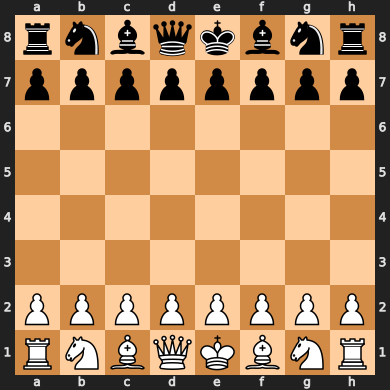

In [4]:
class Chess_Environment(gym.Env):
    """Chess Environment"""
    def __init__(self):
        self.board = chess.Board()
        self.white_pieces = ['P', 'N', 'B', 'R', 'Q', 'K']
        self.black_pieces = [piece.lower() for piece in self.white_pieces]
        self.x_coords, self.y_coords = np.meshgrid(list(range(0, 8)), list(range(0, 8)))
        self.x_coords = self.x_coords / 7
        self.y_coords = self.y_coords / 7
        self.state_size = self.observe()[0].shape
        self.init_action_decoder()
        self.whites_turn = True

    def reset(self):
        """Resets the environment"""
        self.board = chess.Board()
        
    def terminal_test(self):
        """Checks if the game is over"""
        return self.board.is_game_over(claim_draw = True)
    
    def result(self):
        """Gives the end game result"""

        result = self.board.result(claim_draw = True)
        if result == '1-0':
            return 1
        elif result == '0-1':
            return -1
        elif result == '1/2-1/2':
            return 0
        elif result == '*':
            return 0
        else:
            raise Exception('Invalid Result', result)
        
    def legal_actions(self):
        """Provides a list of legal actions in current state"""
        legal_actions = [str(legal_action) for legal_action in list(self.board.legal_moves)]
        return legal_actions
    
    def encode(self):
        """Encodes game state into a string"""
        board_ = self.board.piece_map()
            
        encoded = {
            'board' : board_,
            'turn' : self.board.turn,
            'legal_actions' : self.legal_actions()
        }
        
        return pickle.dumps(encoded)
    
    def decode(self, encoded):
        """Decodes string into game state and sets board and turn"""
        decoded = pickle.loads(encoded)
        self.board.set_piece_map(decoded['board'])
        if decoded['turn'] == False:
            self.board = self.board.mirror()
        self.board.turn = decoded['turn']

    def observe(self):
        """Create observation from the game state"""

        board_ = copy(self.board)
            
        board_ = np.ndarray.flatten(np.array(board_.__str__().split())).reshape(8, 8)
        
        black_pawns = np.isin(copy(board_), ['p']).astype(int)
        black_knights = np.isin(copy(board_), ['n']).astype(int)
        black_rooks = np.isin(copy(board_), ['r']).astype(int)
        black_bishops = np.isin(copy(board_), ['b']).astype(int)
        black_queen = np.isin(copy(board_), ['q']).astype(int)
        black_king = np.isin(copy(board_), ['k']).astype(int)
         
        white_pawns = np.isin(copy(board_), ['P']).astype(int)
        white_knights = np.isin(copy(board_), ['N']).astype(int)
        white_rooks = np.isin(copy(board_), ['R']).astype(int)
        white_bishops = np.isin(copy(board_), ['B']).astype(int)
        white_queen = np.isin(copy(board_), ['Q']).astype(int)
        white_king = np.isin(copy(board_), ['K']).astype(int)
        
        state = np.array([
            white_pawns,
            white_knights,
            white_rooks,
            white_bishops,
            white_queen,
            white_king,
            black_pawns,
            black_knights,
            black_rooks,
            black_bishops,
            black_queen,
            black_king
        ])
        
        return state, self.legal_actions()
    
    def step(self, action):
        """Perform a step in the environment"""
        try:
            self.board.push_uci(action)
        except ValueError:
#             print(f"INVALID ACTION {action}.\nSELECTING A RANDOM ACTION FROM LEGAL ACTIONS\n{self.legal_actions()}")
            actions = random.choices(self.legal_actions())
            self.board.push_uci(actions[0])
            
        self.board = self.board.mirror()
        if self.whites_turn:
            self.whites_turn = False
        else:
            self.whites_turn = True
        return self.observe()
    
    def move_board(self, move):
        """Moves the board positions as per the move"""

        char_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8} 

        int_to_char = {v: k for k, v in char_to_int.items()}

        encoded_board = [(char_to_int[pos[0]], int(pos[1])) for pos in np.ndarray.flatten(BOARD)]

        new_board = [tuple(map(sum, zip((char_to_int[pos[0]], int(pos[1])), move))) for pos in np.ndarray.flatten(BOARD)]
        moves = []
        for pos, new_pos in zip(np.ndarray.flatten(BOARD), new_board):
            try:
                if new_pos[1] > 8:
                    raise Exception()
                if move[2] is None:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}'
                else:
                    move_ = f'{pos}{int_to_char[new_pos[0]]}{new_pos[1]}{move[2]}'
            
                if '-' in move_:
                    raise Exception()
            
                if '0' in move_:
                    raise Exception()
                
            except Exception:
                move_ = 'XXXX'
            moves.append(move_)   
        return np.array(moves).reshape(8, 8)
    
    def init_action_decoder(self):
        """Initialize the decoder to decode the actions"""
        decoder = []
        for key in MOVES.keys():
            decoder_ = self.move_board(MOVES[key])
            decoder.append(decoder_)
#             print(f'Move {key}\n', new_board, '\n')
    
        self.decoder = np.array(decoder)
        self.action_size = self.decoder.shape
        
    def select_action(self, logits):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in self.legal_actions()}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))

        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        return action
    
    def render(self):
        """Render chess board"""
        chess.svg.board(board = self.board)  

env = Chess_Environment()
env.board

# REPLAY BUFFER

In [5]:
class EpisodicReplayBuffer:
    """
    Holds the agents episodes in memory
    """
    def __init__(self, params):
        self.capacity = params['capacity']
        self.memory = deque(maxlen = self.capacity)
        self.gamma = params['gamma']

    def add(self, episodes):
        """
        Stores the episodes in the replay buffer
        """
        for episode in episodes:
            if episode is not None:
                self.memory.append(episode)
                if len(self.memory) > self.capacity:
                    self.memory.popleft() 

    def sample(self, sample_size):
        """
        Return a sample of size of batch size as an experience tuple.
        """
        if len(self.memory) == 0:
            return None
        if len(self.memory) >= sample_size:
            batch = random.sample(self.memory, k = sample_size)
        else:
            batch = random.sample(self.memory, k = len(self.memory))
#         state, actions, returns_, dones = zip(*batch)

#         # Stacks the experiences 
#         # Get inputs into correct shape
#         states = torch.tensor(state).float().to(self.device)
# #         actions = torch.stack(actions).to(self.device)
#         returns_ = torch.tensor(returns_).float().to(self.device)
#         dones = torch.tensor(dones).float().to(self.device)
       
        # print("SAMPLE | STATES", states.shape, "ACTIONS", actions.shape, "P VECTORS", portfolio_vectors.shape,"NEXT STATES", next_states.shape, "REWARDS", rewards.shape, "DONES", dones.shape)
        
        return batch

    def reset_memory(self):
        """Resets the replay buffer"""
        self.memory = deque(maxlen = self.capacity)


# AI AGENT

In [6]:
class Agent:
    
    def __init__(self, decoder, action_size, vae, mdn, controller, test_mode = False, batch_size = 128, lr = 0.2, legal_multiplier = 3, save_freq = 8, train_times = 4, lambda_ = 0.9, gamma = 0.98):
        self.batch_size = batch_size
        self.action_size = action_size
        self.trained_times = 0
        self.train_times = train_times
        self.lambda_ = lambda_
        self.gamma = gamma
        self.legal_multiplier = legal_multiplier # To increase the value of legal actions and MCTS insight as the target policy
        self.decoder = decoder
        self.save_freq = save_freq
        if vae is not None:
            self.vae = CNN_AE(vae, None, 'Latest')
            self.vae.eval()
        if mdn is not None:
            self.mdn = MDN_RNN(mdn, None, 'Latest')
            self.mdn.eval()
            params = {
                'hidden_size' : self.mdn.hidden_size,
                'z_size' : self.vae.z_size,
                'action_size' : action_size,
                'expansion_size': 1200
            }

            if test_mode:
                self.actor = Policy_Controller(controller, None, 'Latest')
                self.critic = Value_Controller(controller, None, 'Latest')
            else:
                self.actor = Policy_Controller(controller, params, False)
                self.critic = Value_Controller(controller, params, False)
                self.actor.save_model(0)
                self.critic.save_model(0)
        
            self.actor_optimizer = Adam(self.actor.parameters(), lr = lr)
            self.critic_optimizer = Adam(self.critic.parameters(), lr = lr)
        
        self.char_to_int = {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8} 
        self.char_to_int_promo = {'r': 1, 'b': 2, 'q': 3, 'k': 4, 'n': 5, '': 6} 
        
        moves_df = pd.DataFrame(list(zip(self.char_to_int.values(), self.char_to_int.keys())), columns = ['Ids', 'Labels'])
        promo_df = pd.DataFrame(list(zip(self.char_to_int_promo.values(), self.char_to_int_promo.keys())), columns = ['Ids', 'Labels'])
        self.move_actions_ohe = pd.get_dummies(moves_df['Ids'])
        self.promo_actions_ohe = pd.get_dummies(promo_df['Ids'])
        
        self.criterion_pi = nn.NLLLoss()
        self.criterion_v = nn.SmoothL1Loss()
    
    def select_action(self, logits, legal_actions):
        """Decodes the output from the NN to legal actions""" 
        decoder_ = np.ndarray.flatten(self.decoder)
        logits_ = np.ndarray.flatten(logits)

        move_logits = [(decoder_[idx].lower(), logits_[idx]) for idx in range(len(logits_))]
        move_logits = dict(move_logits)
        
        legal_move_logits = {legal_action: move_logits[legal_action] for legal_action in legal_actions}
        probabilities = list(legal_move_logits.values()) / sum(list(legal_move_logits.values()))
        
        legal_actions = list(legal_move_logits.keys())
        action = random.choices(list(legal_move_logits.keys()), weights = probabilities, k = 1)[0]
        
        action_probabilities = {legal_actions[idx] : probabilities[idx] for idx in range(len(legal_actions))}
        return action, action_probabilities
    
    def one_hot_encode_action(self, action):
        """One hot encodes the action"""
        if len(action) == 4:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[''] - 1].values
            ]
        else:
            encoded_action = [
                self.move_actions_ohe.loc[
                self.char_to_int[action[0]] - 1].values, 
                self.move_actions_ohe.loc[int(action[1]) - 1].values, 
                self.move_actions_ohe.loc[self.char_to_int[action[2]] - 1].values, 
                self.move_actions_ohe.loc[int(action[3]) - 1].values,
                self.promo_actions_ohe.loc[self.char_to_int_promo[action[4]] - 1].values
            ]
        ohe_action = np.concatenate(encoded_action)
        return ohe_action
    
    def reset(self, batch_size):
        """Resets the MDNs hidden state"""
        self.hidden = self.mdn.init_hidden(batch_size)
        self.hidden = (self.hidden[0].detach().to('cpu'), self.hidden[1].detach().to('cpu'))
        
    def act(self, state, legal_actions):
        """Gets an action from the agent"""
        state = torch.tensor(state).float().unsqueeze(0)
        z = self.vae.encode(state)
    
        zh = torch.cat((z.to('cpu'), self.hidden[0].squeeze(0).to('cpu')), dim = 1)
        if zh.shape[0] > 1:
            raise Exception('Batch size > 1 not handled')
            
        logits = self.actor(zh)
        values = self.critic(zh)
        logits, value = logits.detach().squeeze(0).cpu().numpy(), values.detach().squeeze(0).cpu().numpy()[0]
        action, action_probabilities = self.select_action(logits, legal_actions)
        
        return action_probabilities, value, z
    
    def encode_z(self, state):
        """Encodes the state using the autoencoder"""
        state = torch.tensor(state).float().unsqueeze(0)
        return self.vae.encode(state)
    
    def train(self, episodes):
        """Trains the controller from the MCTS experiences"""
        all_zh = []
        all_returns = []
        all_mcts_action_probs = []
#         batches = [experiences[i : i + self.batch_size] for i in range(0, len(experiences), self.batch_size)]
        for idx, episode in enumerate(episodes):
            zh, mcts_action_probs, rewards, masks = zip(*episode)
            
            zh_ = torch.tensor(zh).float().unsqueeze(1)
            values = self.critic(zh_.to(self.critic.device))
            
            # Calculate GAE
            returns = []
            values_ = list(values.view(-1).detach().cpu().numpy())
            gae = 0

            for i in reversed(range(len(rewards))):
                if i == len(rewards) - 1:
                    delta = rewards[i] - values[i]
                else:
                    delta = rewards[i] + self.gamma * values[i + 1] * masks[i] - values[i]
                gae = delta + self.gamma * self.lambda_ * masks[i] * gae
                returns.insert(0, gae + values[i])
            all_returns.extend(returns)
            all_zh.extend(list(zh))
            all_mcts_action_probs.extend([x for x in mcts_action_probs])
            
#         all_returns = [item for sublist in all_returns for item in sublist]
#         all_zh = [item for sublist in all_zh for item in sublist]
#         all_mcts_action_probs = [item for sublist in all_mcts_action_probs for item in sublist]
        
        # Trains on random experiences to decoralate the information
        idxs = random.choices(range(len(all_zh)), k = self.batch_size)
        mcts_action_probs = [all_mcts_action_probs[idx] for idx in idxs]
        returns = torch.stack([torch.tensor(all_returns[idx]).float() for idx in idxs]).to(self.critic.device)
        actor_zh = torch.stack([torch.tensor(all_zh[idx]).float() for idx in idxs]).to(self.actor.device)
        critic_zh = actor_zh.clone().to(self.critic.device)
        
        logits = self.actor(actor_zh)
        values = self.critic(critic_zh)
                              
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
#             print(zh.is_cuda, type(zh))
        improvement_estimate = self.improvement_estimate(logits, mcts_action_probs)
        epsilon = 1e-7
#             print(logits.shape, torch.log(logits + epsilon))
#             print(improvement_estimate.shape, improvement_estimate)
            
        actor_losses = -improvement_estimate * torch.log(logits + epsilon)
        critic_losses = (returns.view(-1) - values.view(-1)).pow(2)
            
#             print(actor_losses)
#             print("IMP EST", improvement_estimate.shape, "LOGITS", logits.shape, "ACTOR LOSS", actor_losses.shape)
#             print("RETURNS", returns.view(-1).shape, "VALUES", values.view(-1).shape, "CRITIC LOSS", critic_losses.shape)

            
#             for idx in range(logits.shape[0]):
#                 advantage = returns[idx] - values[idx]
#                 # converts logits to action probabilities
# #                 print(values[idx].squeeze(0).shape, returns[idx].shape)
# #                 print(values[idx].squeeze(0), returns[idx])
#                 policy_losses.append(-F.softmax(logits[idx], dim = 0) * advantage)
#                 value_losses.append(F.smooth_l1_loss(values[idx].squeeze(0), returns[idx]))
            
            # sum up all the values of policy_losses and value_losses
        actor_loss = actor_losses.sum()
#             critic_loss = critic_losses.sum()
        critic_loss = critic_losses.sum()
            
#             writer.add_scalar('policy_loss', policy_loss, writer.games)
#             writer.add_scalar('value_loss_loss', value_loss, writer.games)
#             loss = policy_loss + value_loss
            
        print("ACTOR LOSS", actor_loss.item(), "| CRITIC LOSS", critic_loss.item())
        actor_loss.backward()
        self.actor_optimizer.step()
        critic_loss.backward()
        self.critic_optimizer.step()
        if self.trained_times % self.save_freq == 0:
            print("SAVING")
            self.actor.save_model(self.trained_times)
            self.critic.save_model(self.trained_times)
        self.trained_times += 1
        
    def load_hidden(self, hidden):
        """Loads the hidden state to the MDN RNN"""
        self.hidden = deepcopy(hidden)
        
    def get_hidden(self):
        """Gets the hidden state from the MDN RNN"""
        return deepcopy(self.hidden)
    
    def random_controller(self): 
        """Updates the controller from a randomly selected save file"""
        path = f'checkpoints_/{self.actor.type}/{self.actor.name}/'
        list_of_files = [x for x in os.listdir(path) if '.pth' in x]
        file_name = random.choice(list_of_files)
        print(f'Loading Random Controllers {file_name}')
        
        self.actor.load_model(file_name)
        self.critic.load_model(file_name)
        
    def step(self, z, action):
        """Updates the hidden state of the MDN-RNN"""
        z.squeeze_(-1)
        ohe_action = self.one_hot_encode_action(action)
        za = torch.cat((z.to('cpu'), torch.tensor(ohe_action).float().to('cpu').unsqueeze(0)), dim = 1)
        _, self.hidden = self.mdn(za.unsqueeze(1), self.hidden)
        self.hidden = (self.hidden[0].detach().to('cpu'), self.hidden[1].detach().to('cpu'))
        
                
    def improvement_estimate(self, logits, legal_move_logits):
        """Create an improvement estimate by layering the insights from MCTS"""
        new_boards__ = [[x.lower() for x in list(np.ndarray.flatten(self.decoder))] for _ in range(logits.shape[0])]
        improve_est = []
        for idx in range(logits.shape[0]):
            new_boards___ = new_boards__[idx]
            improve_est__ = logits[idx].clone().view(-1)
            improve_est__.data.fill_(0)
            legal_move_logits__ = {k.lower(): v * self.legal_multiplier for k, v in legal_move_logits[idx].items()}
            for move, legal_move_logit in legal_move_logits__.items():
                index = new_boards___.index(move)
                improve_est__[index] += legal_move_logit
            improve_est.append(improve_est__.reshape(76, 8, 8))
        return torch.stack(improve_est)
    
agent = Agent(env.decoder, env.action_size, 'Test', 'Test', 'Test', test_mode = False)
agent.reset(1)


AI Running on cuda

WARNING OVERRIDDING GPU TO RUN ON CPU
CNN_AE(
  (encoder): Sequential(
    (0): Conv(
      (conv): Conv2d(12, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (2): Conv(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (3): Conv(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (4): Conv(
      (conv): Conv2d(256

# TRAINING COACH

In [ ]:
class Coach():
    """
    This class executes the self-play + learning. It uses the functions defined
    in Game and NeuralNet. args are specified in main.py.
    """

    def __init__(self, env, agent, params):
        self.iterations = params['iterations']
        self.episodes = params['episodes']
        self.queue_length = params['queue_length']
        self.simulations = params['simulations']
        self.train_times = params['train_times']
        self.memory_samples = params['memory_samples']
        self.env = deepcopy(env)
        self.agent = agent
        self.trainExamplesHistory = []  # history of examples from args.numItersForTrainExamplesHistory latest iterations
        self.games = 0
        
        params = {
            'capacity' : 300,
            'gamma' : 0.98
        } 
        
        self.memory = EpisodicReplayBuffer(params)
        
 #     @ray.remote   
    def execute_iterations(self, agent, game):
        """Executes several episodes while preserving the MCTS search tree to speed up inference drastically"""
        mcts_white = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = self.simulations)
        mcts_black = MCTS(deepcopy(env), deepcopy(agent), mcts_simulations = self.simulations)  
        mcts_black.agent.random_controller()
        
        episodes = []
        for idx in range(1, self.iterations + 1):
            for idx2 in range(1, self.episodes + 1):
                experiences, mcts_white, mcts_black = self.execute_episode(self.agent, game + idx2 + (idx * self.episodes), mcts_white, mcts_black)
                episodes.append(experiences)
        
        return episodes
            

    def execute_episode(self, agent, game, mcts_white, mcts_black):
        """
        This function executes one episode of self-play, starting with player 1.
        As the game is played, each turn is added as a training example to
        trainExamples. The game is played till the game ends. After the game
        ends, the outcome of the game is used to assign values to each example
        in trainExamples.
        Returns:
            trainExamples: a list of examples of the form (canonicalBoard, currPlayer, pi,v)
                           pi is the MCTS informed policy vector, v is +1 if
                           the player eventually won the game, else -1.
        """
        env = Chess_Environment()
        experiences = []
        agent.reset(1)

       
        game_move = 0
        
        terminal_test = env.terminal_test()
        while not terminal_test:
            encoded_state = env.encode()
            if env.whites_turn: 
                action_probs, zh = mcts_white.action_probabilities(encoded_state)
            else:
                action_probs, zh = mcts_black.action_probabilities(encoded_state)

            if env.whites_turn:
                experiences.append([zh.detach().cpu().numpy(), action_probs, 1, terminal_test]) # mask is 'not done'
            action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
            _, _ = env.step(action)
    
            game_move += 1
            terminal_test = env.terminal_test()
        
        reward = env.result()
        if not env.whites_turn and ((reward == 1) or (reward == -1)):
            reward = reward * -1
        
        experiences[-1][-1] = 0 # mask is 'not done'
        experiences[-1][-2] = reward
        
        if reward == -1:
            print(f"Game {game} White Loss")
        elif reward == 1:
            print(f"Game {game} White Won")
        else:
            print(f"Game {game} Draw")
            print("WARNING DELETING EXPERIENCES")
            return None, mcts_white, mcts_black
        return experiences, mcts_white, mcts_black
    
#     def learn(self, ray):    
    def learn(self):
        """
        Performs numIters iterations with numEps episodes of self-play in each
        iteration. After every iteration, it retrains neural network with
        examples in trainExamples (which has a maximum length of maxlenofQueue).
        It then pits the new neural network against the old one and accepts it
        only if it wins >= updateThreshold fraction of games.
        """
        
#         for i in range(1, self.iterations + 1):
        if PARALLEL:
            episodes = ray.get([self.execute_iterations.remote(self, self.agent, self.games + idx) for idx in range(self.iterations)])
        else:
            episodes = [self.execute_iterations(self.agent, self.games + idx) for idx in range(self.iterations)]
        
        print("EPISODES 1", len(episodes))
        episodes = [item for sublist in episodes for item in sublist]
        self.games += len(episodes) 
        print("EPISODES 2", len(episodes))
        
        
        if episodes is not None:
            self.memory.add(episodes)
        for _ in range(self.train_times):
            episodes = self.memory.sample(self.memory_samples)
            if episodes is not None:
                self.agent.train(episodes)

#         # training new network, keeping a copy of the old one
#         self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         self.pnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         pmcts = MCTS(self.game, self.pnet, self.args)

#         
#         nmcts = MCTS(self.game, self.nnet, self.args)

#         log.info('PITTING AGAINST PREVIOUS VERSION')
#         arena = Arena(lambda x: np.argmax(pmcts.getActionProb(x, temp=0)),
#                           lambda x: np.argmax(nmcts.getActionProb(x, temp=0)), self.game)
#         pwins, nwins, draws = arena.playGames(self.args.arenaCompare)

#         log.info('NEW/PREV WINS : %d / %d ; DRAWS : %d' % (nwins, pwins, draws))
#         if pwins + nwins == 0 or float(nwins) / (pwins + nwins) < self.args.updateThreshold:
#             log.info('REJECTING NEW MODEL')
#             self.nnet.load_checkpoint(folder=self.args.checkpoint, filename='temp.pth.tar')
#         else:
#             log.info('ACCEPTING NEW MODEL')
#             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename=self.getCheckpointFile(i))
#             self.nnet.save_checkpoint(folder=self.args.checkpoint, filename='best.pth.tar')
        
if PARALLEL:
    params = {
        'iterations': 5,
        'episodes': 16,
        'queue_length' : 2000,
        'simulations' : 200,
        'train_times' : 10,
        'memory_samples' : 32
    }
else:
    params = {
        'iterations': 5,
        'episodes': 2,
        'queue_length' : 2000,
        'simulations' : 2,
        'train_times' : 10,
        'memory_samples' : 32
    }

coach = Coach(env, agent, params)
for _ in range(1000):
    if PARALLEL:
        coach.learn(ray)
    else:
        coach.learn()


Loading Random Controllers E88.pth


C:\Users\SanujaPC\AppData\Local\conda\conda\envs\trader\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide


Game 3 Draw
WARNING DELETING EXPERIENCES
Game 4 Draw
WARNING DELETING EXPERIENCES
Game 5 Draw
WARNING DELETING EXPERIENCES
Game 6 Draw
WARNING DELETING EXPERIENCES
Game 7 Draw
WARNING DELETING EXPERIENCES
Game 8 White Won
Game 9 Draw
WARNING DELETING EXPERIENCES
Game 10 Draw
WARNING DELETING EXPERIENCES
Game 11 Draw
WARNING DELETING EXPERIENCES
Game 12 Draw
WARNING DELETING EXPERIENCES
Loading Random Controllers E160.pth
Game 4 White Won
Game 5 Draw
WARNING DELETING EXPERIENCES
Game 6 Draw
WARNING DELETING EXPERIENCES
Game 7 White Loss
Game 8 Draw
WARNING DELETING EXPERIENCES
Game 9 Draw
WARNING DELETING EXPERIENCES
Game 10 White Loss
Game 11 Draw
WARNING DELETING EXPERIENCES
Game 12 Draw
WARNING DELETING EXPERIENCES
Game 13 Draw
WARNING DELETING EXPERIENCES
Loading Random Controllers E128.pth
Game 5 Draw
WARNING DELETING EXPERIENCES
Game 6 Draw
WARNING DELETING EXPERIENCES
Game 7 Draw
WARNING DELETING EXPERIENCES
Game 8 Draw
WARNING DELETING EXPERIENCES
Game 9 Draw
WARNING DELETING EX

C:\Users\SanujaPC\AppData\Local\conda\conda\envs\trader\lib\site-packages\ipykernel_launcher.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ACTOR LOSS 2865.5048828125 | CRITIC LOSS 175.30995178222656
SAVING
ACTOR LOSS 5327.7236328125 | CRITIC LOSS 3457196.5
ACTOR LOSS 5831.173828125 | CRITIC LOSS 57.04170227050781
ACTOR LOSS 5950.3232421875 | CRITIC LOSS 411.44354248046875
ACTOR LOSS 5849.05859375 | CRITIC LOSS 328.6885070800781
ACTOR LOSS 5968.5556640625 | CRITIC LOSS 304.3631896972656
ACTOR LOSS 5951.681640625 | CRITIC LOSS 253.7970428466797
ACTOR LOSS 5892.7451171875 | CRITIC LOSS 178.30711364746094
ACTOR LOSS 6014.52978515625 | CRITIC LOSS 108.84473419189453
SAVING
ACTOR LOSS 6021.02099609375 | CRITIC LOSS 83.01626586914062
Loading Random Controllers E32.pth
Game 53 Draw
WARNING DELETING EXPERIENCES
Game 54 Draw
WARNING DELETING EXPERIENCES
Game 55 Draw
WARNING DELETING EXPERIENCES
Game 56 Draw
WARNING DELETING EXPERIENCES
Game 57 Draw
WARNING DELETING EXPERIENCES
Game 58 Draw
WARNING DELETING EXPERIENCES
Game 59 Draw
WARNING DELETING EXPERIENCES
Game 60 Draw
WARNING DELETING EXPERIENCES
Game 61 Draw
WARNING DELETING E

ACTOR LOSS 5309.2607421875 | CRITIC LOSS 185.71524047851562
ACTOR LOSS 5136.9599609375 | CRITIC LOSS 97.59239196777344
SAVING
ACTOR LOSS 5245.947265625 | CRITIC LOSS 143.8649444580078
ACTOR LOSS 4007.33935546875 | CRITIC LOSS 172.39842224121094
ACTOR LOSS 5036.11279296875 | CRITIC LOSS 112135.84375
ACTOR LOSS 4978.6220703125 | CRITIC LOSS 6168.53125
ACTOR LOSS 4853.4365234375 | CRITIC LOSS 14197.546875
ACTOR LOSS 2724.237548828125 | CRITIC LOSS 442.3494873046875
ACTOR LOSS 4631.40966796875 | CRITIC LOSS 63.10688400268555
Loading Random Controllers E176.pth


# EVALUATION

In [ ]:
class MainWindow(QWidget):
    def __init__(self):
        super().__init__()
        self.setGeometry(100, 100, 1100, 1100)
        self.widgetSvg = QSvgWidget(parent = self)
        self.widgetSvg.setGeometry(10, 10, 1080, 1080)


# board = chess.Board()
# app = QApplication([])
# window = MainWindow()
# window.show()
# app.exec()

In [ ]:
class Arena:
    """An Arena where you can have two players fight"""
    
    def __init__(self, env, agent):
        self.env = env        
        self.agent = agent
        self.root = tk.Tk()
        self.root.withdraw()
        self.app = QApplication([])
        self.window = MainWindow()
    
    def vs_human(self):
        """Fight Against the AI"""
        self.agent = Agent(self.env.decoder, self.env.action_size, 'Test', 'Test', 'Test', test_mode = True)
        self.mcts_black = MCTS(deepcopy(self.env), deepcopy(self.agent), mcts_simulations = 20)
        
        self.env.reset()
        self.mcts_black.reset()
        game_move = 0
        while not self.env.terminal_test():
            if not self.env.whites_turn:
                encoded_state = self.env.encode()
                action_probs, zh = self.mcts_black.action_probabilities(encoded_state, temp = 0)
                
                figureObject, axesObject = plt.subplots()
                # Draw the pie chart
                axesObject.pie(list(action_probs.values()), labels = list(action_probs.keys()), autopct = '%1.2f', startangle = 90)
                # Aspect ratio - equal means pie is a circl
                axesObject.axis('equal')
                plt.show()
                
                
                action = random.choices(list(action_probs.keys()), weights = action_probs.values(), k = 1)[0]
            else:
                legal_actions = self.env.legal_actions() 
                self.render()
                action = simpledialog.askstring(title = "Move", prompt = f"What's your next move?\n{legal_actions}")
                while action not in legal_actions:
                    action = simpledialog.askstring(title = "Move", prompt = f"Invalid Move. What's your next move?\n{legal_actions}")
                    if action is None:
                        break
                if action is None:
                    break
            
            _, _ = self.env.step(action)
            game_move += 1   
        print(env.result())
        
    def render(self):
        """Renders the chess board"""
        chessboardSvg = chess.svg.board(self.env.board).encode("UTF-8")
        self.window.widgetSvg.load(chessboardSvg)
        self.window.show()
        self.app.exec()
        
        
arena = Arena(env, agent)
arena.vs_human()